<a href="https://colab.research.google.com/github/ykkimhgu/DLIP-src/blob/main/Tutorial_Pytorch/Assignment_PyTorch_T3_3_Transfer_Learning_using_Pre_trained_Models_(classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DLIP Tutorial - PyTorch**
# Transfer Learning using Pre-trained Models (Classification) - Assignment

Y.-K. Kim
(updated 2022. 5. 10) 

===================

Create a CNN model 'EfficientNet(efficientnet_b7)' and Train with Custom Dataset

## For CoLab Usage:

1. Download this notebook
2. Then, open in Colab

# Environment Setup

Download Python modules and image data. 
- [download modules](https://drive.google.com/file/d/1hjrWkcvBTiI-5yGtWPvsYVdaE7YLNWDo/view?usp=sharing)
- [download dataset(cat/dog)](https://drive.google.com/file/d/1KYOAxXDIqp_hhE97WWQ_C8TeGFHWkxqG/view?usp=sharingg)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from set_parameter_requires_grad import set_parameter_requires_grad
from initialize_model import initialize_model
from train import train
from test import test

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")
if torch.cuda.is_available(): print(f'Device name: {torch.cuda.get_device_name(0)}') 


Using cuda device
Device name: NVIDIA GeForce RTX 3060 Laptop GPU


# MODEL

Basically, the classification models provided by torchvision are trained on ImageNet and consist of 1000 output layers.

However, in the model for fine-tuning with other datasets, the number of output layers should be different depending on the class.

Here, we use the initialize_model() function provided in the [pytorch tutorial](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html) to change the output stage of the model.

initialize_model() is a function that helps to initialize the fine-tuning of some models.

If the model is not in the function, the output layer information can be known by printing the model with the print() function.

In [2]:
pip install efficientnet_pytorch

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception*]
model_name = "efficientnet_b7"
# model_name = "resnet"


# Number of classes in the dataset
num_classes = 2

feature_extract = True   # True: only update the reshaped layer params, False: finetune the whole model, 

####################################################################
### add your code for 'efficientnet_b7' in 'initialize_model.py' ###
####################################################################

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)  
print(model_ft)
print(input_size)
model_ft = model_ft.to(device)


from torchsummary import summary
summary(model_ft, (3,input_size,input_size))

Loaded pretrained weights for efficientnet-b7
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        64, 16, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        16, 64, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        64, 32, ke

# Prepare Datasets: kaggle cats and dogs

**TO DO**

download the kaggle cats and dogs dataset: [download link](https://www.microsoft.com/en-us/download/details.aspx?id=54765)

In [4]:
### ADD YOUR CODE HERE
import shutil
import os
# unzip using shutil module .... (if necessary)

The images in the prepared dataset have different sizes. In order to be used as a learning model, the following process is required. (refer to part2)

- Assign the images in the folder to training/test data for learning
- Same pre-processing as ImageNet data for input of learning model

In [5]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure

data_dir = "./kagglecatsanddogs/PetImages"

# Data augmentation and normalization for training
# Just normalization for validation

transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

training_data = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform['train'])
test_data = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform['test'])

classes = ['Cat', 'Dog']
print(f"train dataset length = {len(training_data)}")
print(f"test  dataset length = {len(test_data)}")

Initializing Datasets and Dataloaders...
train dataset length = 17501
test  dataset length = 7497


Use DataLoader to make dataset iterable.

In [6]:
# Batch size for training (change depending on how much memory you have)
batch_size = 8

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {y.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([8, 3, 600, 600]) torch.int64
Shape of y: torch.Size([8]) torch.int64


# Optimization Setup

### Optmizer function 
 Gradient descent is the common optimisation strategy used in neural networks. Many of the variants and advanced optimisation functions now are available, 
  
- Stochastic Gradient Descent, Adagrade, Adam, etc

### Loss function

- Linear regression->Mean Squared Error
- Classification->Cross entropy

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(), lr = 0.001, momentum=0.9,weight_decay=5e-4)

# Train and Test the model

In [8]:
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_ft, loss_fn, optimizer, device, 15)
    test(test_dataloader, model_ft, loss_fn, device)
print("Done!")

Epoch 1
-------------------------------
loss: 0.729729  [    0/17501]
loss: 0.640516  [  120/17501]
loss: 0.665296  [  240/17501]
loss: 0.547953  [  360/17501]
loss: 0.565430  [  480/17501]
loss: 0.486478  [  600/17501]
loss: 0.601854  [  720/17501]
loss: 0.506264  [  840/17501]
loss: 0.395218  [  960/17501]
loss: 0.366030  [ 1080/17501]
loss: 0.383096  [ 1200/17501]
loss: 0.352766  [ 1320/17501]
loss: 0.450035  [ 1440/17501]
loss: 0.433047  [ 1560/17501]
loss: 0.476979  [ 1680/17501]
loss: 0.355077  [ 1800/17501]
loss: 0.484408  [ 1920/17501]
loss: 0.415621  [ 2040/17501]
loss: 0.417497  [ 2160/17501]
loss: 0.394574  [ 2280/17501]
loss: 0.333229  [ 2400/17501]
loss: 0.682531  [ 2520/17501]
loss: 0.340165  [ 2640/17501]
loss: 0.561917  [ 2760/17501]
loss: 0.467862  [ 2880/17501]
loss: 0.402902  [ 3000/17501]
loss: 0.276533  [ 3120/17501]
loss: 0.313402  [ 3240/17501]
loss: 0.260045  [ 3360/17501]
loss: 0.391876  [ 3480/17501]
loss: 0.380528  [ 3600/17501]
loss: 0.220867  [ 3720/17501]


c:\Users\skrua\miniconda3\envs\py39\lib\site-packages\PIL\TiffImagePlugin.py:866: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Test Error: 
 Accuracy: 98.6%, Avg loss: 0.106594 

Epoch 2
-------------------------------
loss: 0.653413  [    0/17501]
loss: 0.354494  [  120/17501]
loss: 0.160108  [  240/17501]
loss: 0.736991  [  360/17501]
loss: 0.381095  [  480/17501]
loss: 0.152053  [  600/17501]
loss: 0.200489  [  720/17501]
loss: 0.264467  [  840/17501]
loss: 0.397659  [  960/17501]
loss: 0.173448  [ 1080/17501]
loss: 0.444446  [ 1200/17501]
loss: 0.129487  [ 1320/17501]
loss: 0.062180  [ 1440/17501]
loss: 0.290966  [ 1560/17501]
loss: 0.380263  [ 1680/17501]
loss: 0.100199  [ 1800/17501]
loss: 0.777494  [ 1920/17501]
loss: 0.354428  [ 2040/17501]
loss: 0.486787  [ 2160/17501]
loss: 0.384469  [ 2280/17501]
loss: 0.132213  [ 2400/17501]
loss: 0.569623  [ 2520/17501]
loss: 0.173367  [ 2640/17501]
loss: 0.219005  [ 2760/17501]
loss: 0.090217  [ 2880/17501]
loss: 0.199883  [ 3000/17501]
loss: 0.708578  [ 3120/17501]
loss: 0.116070  [ 3240/17501]
loss: 0.193382  [ 3360/17501]
loss: 0.169721  [ 3480/17501]
loss: 0.

# Visualize test results

Select random test images and evaluate

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


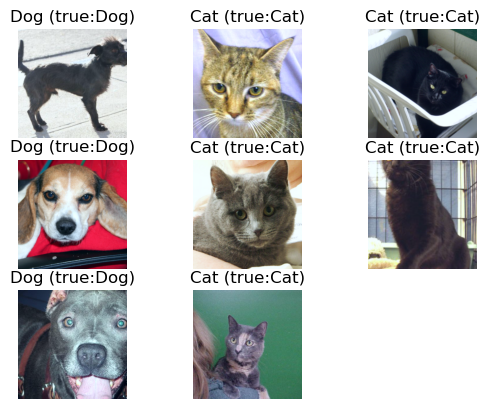

In [9]:
# Get some random test  images // BatchSize at a time
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    pred = model_ft(images)
    _, predicted = torch.max(pred.data, 1);

figure = plt.figure()
num_of_images = min(batch_size, 9)

for index in range(num_of_images):
    plt.subplot(3, 3, index+1)
    plt.axis('off')    
    plt.title(f"Ground Truth: {classes[labels[index]]}")
    plt.title(f"{classes[predicted[index].item()]} (true:{classes[labels[index]]})")
    plt.imshow(np.transpose((images[index] * 0.224  + 0.456).cpu().numpy().squeeze(), (1, 2, 0)))  # 출력을 위한 차원변환 (channels*rows*cols) -> (rows*cols*channels)

Plot heatmap (confusion matrix)

      Cat   Dog
Cat  3690    59
Dog    47  3701


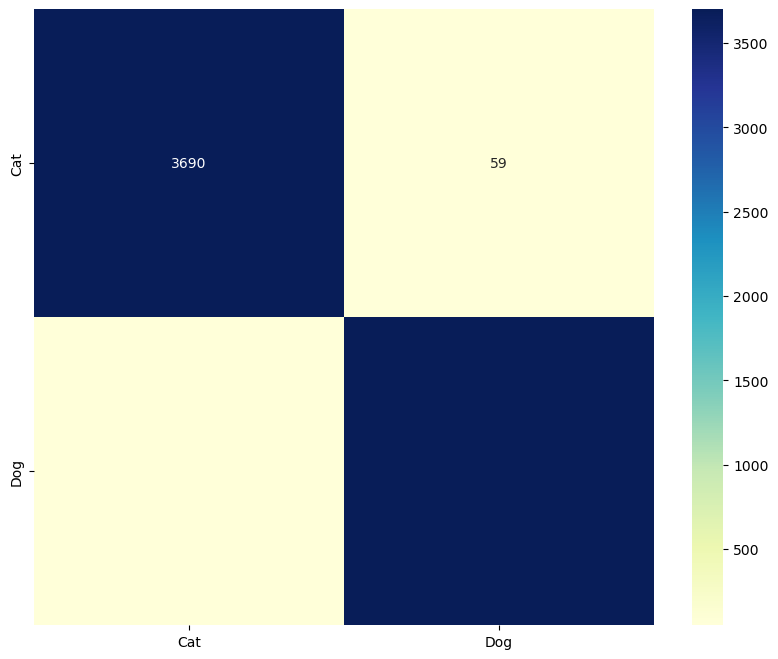

In [10]:
# Get some random test  images // BatchSize at a time
heatmap = pd.DataFrame(data=0,index=classes,columns=classes)

for images, labels in test_dataloader:
    with torch.no_grad():
        images, labels = images.to(device), labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            true_label = labels[i].item()
            predicted_label = predicted[i].item()
            heatmap.iloc[true_label, predicted_label] += 1
print(heatmap)
_, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(heatmap, annot=True, fmt="d", cmap="YlGnBu")
plt.show()

# Saving Models
* save the structure of this class together with the model

In [11]:
torch.save(model_ft, f"{model_name}_ft(T3_3).pth")